In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PyTorchEstimator import PyTorchEstimator
from PyTorchModel import PyTorchModel
from azureml.core.workspace import Workspace
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import udf

import pyspark
spark = pyspark.sql.SparkSession.builder.appName("MyApp2").getOrCreate()
#    .config("spark.jars.packages", "Azure:mmlspark:0.17") \
sc = spark.sparkContext
import mmlspark

In [3]:
# Get the CIFAR10 dataset as Python dictionary
import os, tarfile, pickle
import urllib.request
cdnURL = "https://amldockerdatasets.azureedge.net"
# Please note that this is a copy of the CIFAR10 dataset originally found here:
# http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
dataFile = "cifar-10-python.tar.gz"
dataURL = cdnURL + "/CIFAR10/" + dataFile
if not os.path.isfile(dataFile):
    urllib.request.urlretrieve(dataURL, dataFile)
with tarfile.open(dataFile, "r:gz") as f:
    test_dict = pickle.load(f.extractfile("cifar-10-batches-py/test_batch"),
                            encoding="latin1")

[[[ 23  19  21 ... 200 199 197]
  [ 23  19  21 ... 205 204 202]
  [ 23  20  23 ... 211 208 206]
  ...
  [194 177 176 ... 149 148 141]
  [172 157 165 ... 140 149 152]
  [151 134 144 ... 149 155 150]]

 [[ 19  21  16 ... 155 152 151]
  [ 20  20  17 ... 168 164 163]
  [ 20  20  20 ... 173 169 166]
  ...
  [196 179 179 ... 131 130 123]
  [177 161 170 ... 122 130 134]
  [157 140 151 ... 132 137 132]]

 [[ 23  28  19 ... 125 122 120]
  [ 24  27  20 ... 133 129 128]
  [ 24  26  23 ... 139 136 132]
  ...
  [163 144 141 ... 117 116 110]
  [142 126 131 ... 108 116 119]
  [123 104 112 ... 118 123 118]]]


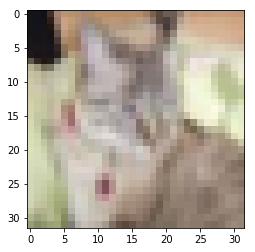

In [4]:
# Check that images look right
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

print(test_dict["data"][8].reshape(3,32,32))
imgplot = plt.imshow(test_dict["data"][8].reshape(3,32,32).transpose([1, 2, 0]))

In [8]:
from petastorm.unischema import dict_to_spark_row, Unischema, UnischemaField
from petastorm.codecs import ScalarCodec, NdarrayCodec, CompressedImageCodec
from pyspark.sql.types import *
from pyspark.sql import Row
import numpy as np
import cv2
from collections import OrderedDict

# Generate Petastorm dataset
image_zip = zip(test_dict["data"], test_dict["labels"])

# CIFARSchema = Unischema('CIFARSchema', [
#     UnischemaField('image', np.uint8, (32,32,3), CompressedImageCodec('png'), False),
#     UnischemaField('label', np.int64, (), ScalarCodec(IntegerType()), False)
# ])

def format_image(record):
    image, label = record
    
    reshaped_image = image.reshape(3,32,32).transpose([1, 2, 0])
    _, encoded_image = cv2.imencode('.jpg', reshaped_image)
    serialized_image = bytearray(encoded_image)
    
    print("TYPE OF SERIALIZED: ", type(serialized_image))
    
    return {'image': serialized_image, 
            'label': label}

def convert_to_row(d: dict) -> Row:
    return Row(**OrderedDict(sorted(d.items())))

imagesWithLabels = sc.parallelize(image_zip) \
            .map(format_image) \
            .map(convert_to_row) \
            .toDF()

#             .map(lambda x: dict_to_spark_row(CIFARSchema, x))

# imagesWithLabels = spark.createDataFrame(rows_rdd)

DataFrame[image: binary, label: bigint]
<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
# Split the images with labels into a train and test data
train, test = imagesWithLabels.randomSplit([0.8, 0.2], seed=123)

In [ ]:
test.show(5)
test.printSchema()

In [ ]:
# Initializing the estimator
workspace = Workspace('e54229a3-0e6f-40b3-82a1-ae9cda6e2b81', 'mmlspark-serano', 'playground')
clusterName = 'train-target'
trainingScript = '/home/azureuser/mmlspark/src/pytorch/pytorch_train.py'
modelScript = '/home/azureuser/mmlspark/src/pytorch/pytorch_net.py'
nodeCount = 1
modelPath = './outputs/model'
experimentName = 'pytorch-train-cifar'
unischema = CIFARSchema

estimator = PyTorchEstimator(workspace, clusterName, trainingScript, modelScript, nodeCount, modelPath, experimentName, unischema)

In [ ]:
model = estimator.fit(train)

In [ ]:
# Optional dev checkpoint. Use 7h-trained model
from azureml.core import Experiment

# runId = 'pytorch-train-cifar_1561412083_43a28b53'  #7h-trained model
runId = 'pytorch-train-cifar_1561654773_b92fb2c6'
experiment = Experiment(workspace, name=experimentName)

model = PyTorchModel(runId, experiment, workspace, modelPath, unischema)

In [ ]:
def preprocess(data):
    # ===================== WIP ========================
    # Decode image to preprocess it
    codec = CIFARSchema.fields["image"].codec
    decoded = codec.decode(CIFARSchema.fields["image"], data)
    
    # normalize
    decoded = np.divide(decoded, 255)
    decoded[:,:,0] = (decoded[:,:,0] - 0.4914)/0.2023
    decoded[:,:,1] = (decoded[:,:,1] - 0.4822)/0.1994
    decoded[:,:,2] = (decoded[:,:,2] - 0.4465)/0.2010
    
    # Encode image again after preprocessing
    encoded = codec.encode(CIFARSchema.fields["image"], decoded)
    # ===================== WIP ========================
    return encoded

preprocessUDF = udf(preprocess, BinaryType())

In [ ]:
test_preprocessed = test.withColumn("image", preprocessUDF("image"))
scoredImages = model.setInputCol("image").setOutputCol("scored") \
                    .transform(test)

In [ ]:
test_preprocessed.printSchema()
test_preprocessed.show(3)

In [ ]:
scoredImages.printSchema()
scoredImages.show(3)

In [ ]:
# Transform the log probabilities to predictions
def argmax(x):
    return max(enumerate(x),key=lambda p: p[1])[0]

argmaxUDF = udf(argmax, IntegerType())
imagePredictions = scoredImages.withColumn("prediction", argmaxUDF("scored"))\
                               .select("prediction", "label")

In [ ]:
predictions = np.array(imagePredictions.select("prediction").collect()).reshape(-1)
labels = np.array(imagePredictions.select("label").collect()).reshape(-1)
print("Predictions shape: {} Labels shape: {}".format(predictions.shape, labels.shape))

correct = np.count_nonzero(predictions == labels)
total = predictions.shape[0]

print("Accuracy: {}% [{}/{}]".format(100. * correct/total, correct, total))

In [ ]:
print("predictions: ", predictions)